# Testing clustering with the Porto Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from sklearn.cluster import KMeans

/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [25]:
df = pd.read_csv("../datasets/Dataset.csv", decimal=",")
df_index = pd.DataFrame(pd.date_range('2019-01-01', periods=35136, freq='15T'))
df = pd.concat([pd.DataFrame(df_index).rename(columns={0: "Time"}),df],axis=1)
df

,Time,0,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,50
0,2019-01-01 00:00:00,2.964,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,...,0.898895,0.203825,0.221624,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475
1,2019-01-01 00:15:00,2.584,2.371797,1.544607,0.778310,1.962012,2.733737,0.192929,0.558967,0.358525,...,0.917793,0.165311,0.179747,0.319531,0.848467,0.944434,0.177722,0.222940,1.011313,0.795863
2,2019-01-01 00:30:00,3.071,2.415961,1.319880,0.665072,1.676555,2.784640,0.382869,1.109272,0.377198,...,0.934883,0.328060,0.356708,0.336174,0.864266,0.962019,0.352691,0.442426,1.030144,0.810682
3,2019-01-01 00:45:00,2.694,2.302538,1.319880,0.665072,1.676555,2.653908,0.442052,1.280743,0.377198,...,0.890992,0.378772,0.411848,0.336174,0.823691,0.916855,0.407209,0.510816,0.981781,0.772623
4,2019-01-01 01:00:00,2.569,2.363063,0.913154,0.460128,1.159919,2.723669,0.192242,0.556976,0.668500,...,0.914413,0.164722,0.179106,0.595793,0.845343,0.940956,0.177089,0.222146,1.007588,0.792932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,2020-01-01 22:45:00,1.664,2.244719,1.455982,0.733653,1.849437,2.587266,0.205654,0.595835,0.171793,...,0.868619,0.176214,0.191602,0.153109,0.803007,0.893832,0.189444,0.237645,0.957128,0.753222
35132,2020-01-01 23:00:00,1.659,2.136340,1.201186,0.605264,1.525786,2.462348,0.201219,0.582985,0.067223,...,0.826680,0.172414,0.187470,0.059912,0.764237,0.850676,0.185359,0.232519,0.910916,0.716855
35133,2020-01-01 23:15:00,1.664,2.192805,1.201186,0.605264,1.525786,2.527430,0.228585,0.662271,0.067223,...,0.848530,0.195862,0.212966,0.059912,0.784436,0.873160,0.210568,0.264142,0.934992,0.735802
35134,2020-01-01 23:30:00,1.697,1.446083,0.259545,0.130782,0.329682,1.666757,0.189302,0.548459,0.070958,...,0.559578,0.162203,0.176368,0.063241,0.517310,0.575820,0.174381,0.218749,0.616596,0.485237


In [3]:
# unique_locations = df['Location'].unique()
# lists_per_location = []
# for location in unique_locations:
#     values = df.loc[df['Location'] == location, 'Energy'].tolist()
#     lists_per_location.append(values)
# len(lists_per_location)

In [4]:
# x = lists_per_location[1]
# y = lists_per_location[2]
# formatted_dataset = to_time_series_dataset(lists_per_location[:5])
# formatted_dataset.shape

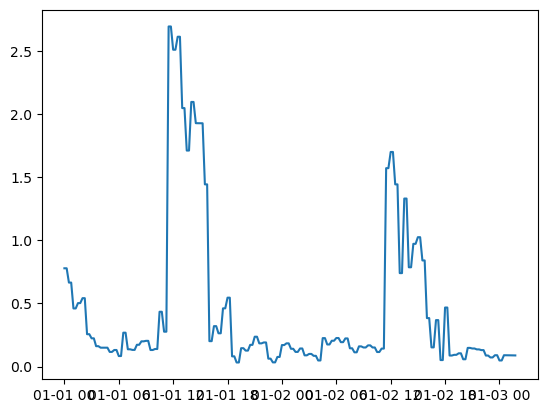

In [26]:
plt.plot(df.iloc[:200,0],df.iloc[:200,4])
plt.show()

In [31]:
undersample_data = df.loc[np.linspace(df.index.min(),df.index.max(),3000).astype(int)]
#undersample_time = df_index.loc[np.linspace(df_index.index.min(),df_index.index.max(),8784).astype(int)]
undersample_data = undersample_data.reset_index().drop('index',axis=1)
undersample_data

,Time,0,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,50
0,2019-01-01 00:00:00,2.964,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,...,0.898895,0.203825,0.221624,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475
1,2019-01-01 02:45:00,3.047,2.443886,0.508011,0.255981,0.645293,2.816826,0.236496,0.685193,0.317444,...,0.945689,0.202642,0.220337,0.282918,0.874256,0.973139,0.217856,0.273284,1.042051,0.820053
2,2019-01-01 05:45:00,3.358,2.208429,0.259545,0.130782,0.329682,2.545438,0.086792,0.251459,0.209140,...,0.854576,0.074367,0.080861,0.186393,0.790025,0.879381,0.079951,0.100293,0.941654,0.741044
3,2019-01-01 08:45:00,2.578,2.244719,0.395647,0.199362,0.502565,2.587266,0.195787,0.567247,0.425748,...,0.868619,0.167760,0.182409,0.379444,0.803007,0.893832,0.180355,0.226243,0.957128,0.753222
4,2019-01-01 11:30:00,2.846,2.382500,5.347570,2.694579,6.792662,2.746072,0.414973,1.202286,0.179262,...,0.921935,0.355569,0.386618,0.159766,0.852296,0.948695,0.382264,0.479524,1.015876,0.799454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2020-01-01 12:00:00,1.667,1.290956,0.246884,0.124402,0.313600,1.487958,1.117284,3.237067,0.130712,...,0.499550,0.957343,1.040941,0.116496,0.461816,0.514050,1.029218,1.291082,0.550452,0.433184
2996,2020-01-01 14:45:00,1.697,0.885487,0.324431,0.163477,0.412103,1.020614,1.712793,4.962414,0.268894,...,0.342649,1.467604,1.595760,0.239649,0.316767,0.352595,1.577789,1.979225,0.377564,0.297128
2997,2020-01-01 17:45:00,1.679,1.535517,3.203161,1.614036,4.068762,1.769839,0.989035,2.865495,0.276363,...,0.594185,0.847453,0.921455,0.246305,0.549303,0.611433,0.911078,1.142883,0.654731,0.515247
2998,2020-01-01 20:45:00,1.659,1.589276,1.436991,0.724083,1.825314,1.831802,1.660324,4.810397,0.052285,...,0.614988,1.422646,1.546876,0.046598,0.568535,0.632839,1.529456,1.918594,0.677653,0.533286


Text(0, 0.5, 'Temperature')

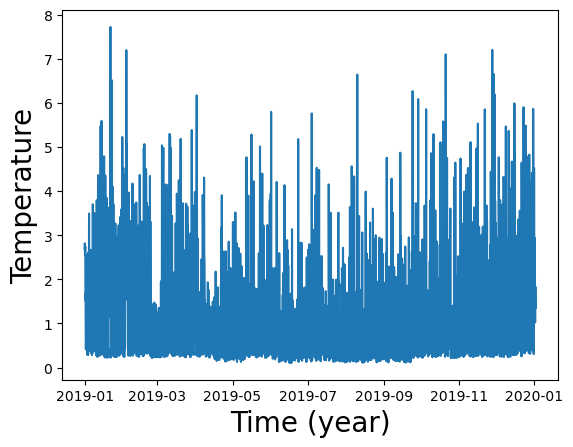

In [32]:
plt.plot(undersample_data.Time,undersample_data["5"])
plt.xlabel('Time (year)',fontsize=20)
plt.ylabel('Temperature',fontsize=20)

In [ ]:
data_array = np.array(undersample_data.T.drop('Time').values)
model = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10)
model.fit(data_array)
cities_list = undersample_data.T.drop('Time').index.tolist()

In [ ]:
cities_list

8784

In [10]:
y=model.predict(data_array)

/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 8784 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [21]:
y

array([3, 3, 3, ..., 1, 3, 1])

In [11]:
# Executed with 1-hour intervals
y = np.array([1, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Executed with 1500 records linearly spaced
y = np.array([2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [37]:
x = undersample_time

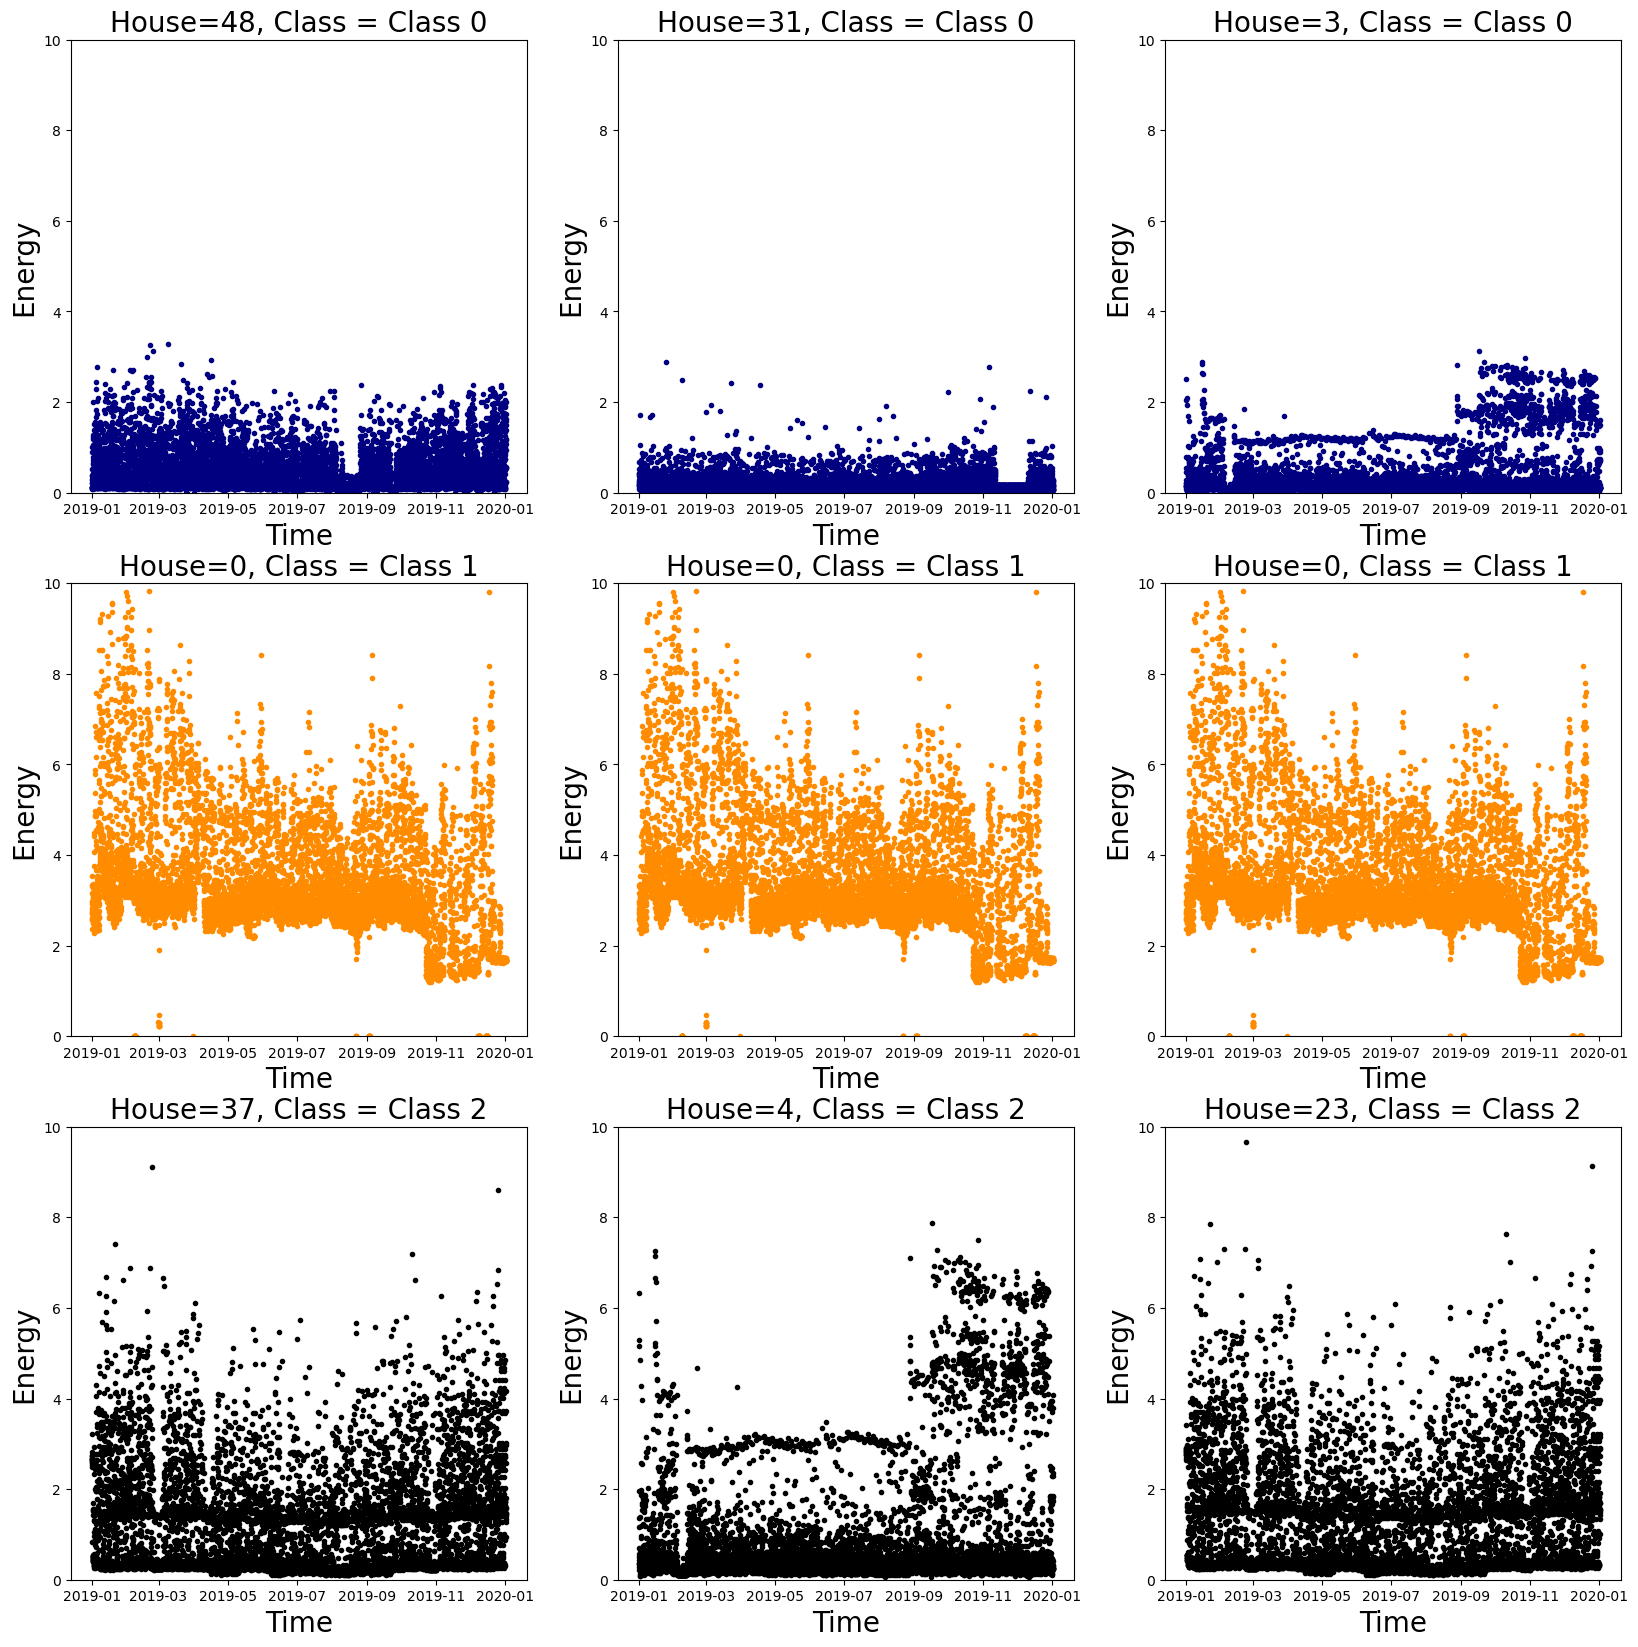

In [38]:
plt.figure(figsize=(20,20))
k_dict = {'1':0,'2':0,'3':0,'4':1,'5':1,'6':1,'7':2,'8':2,'9':2}
colors = ['navy']*3+['darkorange']*3+['k']*3
Names = ['Class 0']*3+['Class 1']*3+['Class 2']*3
for j in range(1,10):
    plt.subplot(3,3,j)
    k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(x,data_array[k],'.',color=colors[j-1])
    plt.ylabel('Energy',fontsize=20)
    plt.xlabel('Time',fontsize=20)
    plt.title('House=%s, Class = %s'%(cities_list[k],Names[j-1]),fontsize=20)
    plt.ylim(0,10)

In [13]:
class0 = np.where(y == 0)[0]
class1 = np.where(y == 1)[0]
class2 = np.where(y == 2)[0]
len(class0),len(class1),len(class2)

(37, 1, 13)

In [14]:
cluster0 = df.iloc[:, class0]
cluster0

,2,3,6,8,10,13,14,15,16,17,...,41,42,43,44,45,46,47,48,49,50
0,1.544607,0.778310,0.237877,0.358525,0.232600,1.036778,1.390459,2.093229,0.255332,0.757369,...,0.898895,0.203825,0.221624,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475
1,1.544607,0.778310,0.192929,0.358525,0.188649,1.036778,1.390459,2.137238,0.207086,0.757369,...,0.917793,0.165311,0.179747,0.319531,0.848467,0.944434,0.177722,0.222940,1.011313,0.795863
2,1.319880,0.665072,0.382869,0.377198,0.374375,1.090776,1.188159,2.177034,0.410963,0.796816,...,0.934883,0.328060,0.356708,0.336174,0.864266,0.962019,0.352691,0.442426,1.030144,0.810682
3,1.319880,0.665072,0.442052,0.377198,0.432246,1.090776,1.188159,2.074828,0.474490,0.796816,...,0.890992,0.378772,0.411848,0.336174,0.823691,0.916855,0.407209,0.510816,0.981781,0.772623
4,0.913154,0.460128,0.192242,0.668500,0.187977,1.933158,0.822024,2.129367,0.206348,1.412178,...,0.914413,0.164722,0.179106,0.595793,0.845343,0.940956,0.177089,0.222146,1.007588,0.792932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,1.455982,0.733653,0.205654,0.171793,0.201092,0.496789,1.310679,2.022727,0.220745,0.362906,...,0.868619,0.176214,0.191602,0.153109,0.803007,0.893832,0.189444,0.237645,0.957128,0.753222
35132,1.201186,0.605264,0.201219,0.067223,0.196755,0.194396,1.081310,1.925066,0.215984,0.142007,...,0.826680,0.172414,0.187470,0.059912,0.764237,0.850676,0.185359,0.232519,0.910916,0.716855
35133,1.201186,0.605264,0.228585,0.067223,0.223514,0.194396,1.081310,1.975947,0.245358,0.142007,...,0.848530,0.195862,0.212966,0.059912,0.784436,0.873160,0.210568,0.264142,0.934992,0.735802
35134,0.259545,0.130782,0.189302,0.070958,0.185103,0.205196,0.233643,1.303072,0.203193,0.149896,...,0.559578,0.162203,0.176368,0.063241,0.517310,0.575820,0.174381,0.218749,0.616596,0.485237


In [15]:
cluster0.to_csv("data/porto_cluster0.csv", index=None)

In [100]:
cluster1 = df.iloc[:, class1]
cluster1

,0
0,2.964
1,2.584
2,3.071
3,2.694
4,2.569
...,...
35131,1.664
35132,1.659
35133,1.664
35134,1.697


In [16]:
cluster2 = df.iloc[:, class2]
cluster2

,1,4,5,7,9,11,12,23,29,30,32,33,37
0,2.322959,1.962012,2.677445,0.689194,0.814643,0.807722,2.686248,2.810089,0.524345,3.130360,0.664271,2.557168,2.648362
1,2.371797,1.962012,2.733737,0.558967,0.660712,0.655099,2.686248,2.869169,0.425267,3.196173,0.538753,2.610930,2.704042
2,2.415961,1.676555,2.784640,1.109272,1.311186,1.300046,2.295421,2.922594,0.843945,3.255687,1.069158,2.659547,2.754392
3,2.302538,1.676555,2.653908,1.280743,1.513868,1.501006,2.295421,2.785386,0.974402,3.102841,1.234428,2.534688,2.625081
4,2.363063,1.159919,2.723669,0.556976,0.658358,0.652765,1.588079,2.858603,0.423752,3.184403,0.536834,2.601315,2.694084
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,2.244719,1.849437,2.587266,0.595835,0.704291,0.698307,2.532119,2.715443,0.453317,3.024926,0.574288,2.471040,2.559163
35132,2.136340,1.525786,2.462348,0.582985,0.689101,0.683247,2.088998,2.584336,0.443540,2.878877,0.561902,2.351733,2.435601
35133,2.192805,1.525786,2.527430,0.662271,0.782819,0.776169,2.088998,2.652642,0.503862,2.954968,0.638321,2.413892,2.499977
35134,1.446083,0.329682,1.666757,0.548459,0.648292,0.642784,0.451378,1.749330,0.417273,1.948704,0.528626,1.591882,1.648652


In [17]:
cluster2.to_csv("data/porto_cluster2.csv", index=None)

In [ ]:
## Compare gains of cluster with normal runs